## Predicting Concrete Strength - Linear Regression vs Random Forest Regressor

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skew import skew_label

### Define Functions

In [2]:
def showoutliers(df, column_name):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        return outliers

def countoutliers(df, column_name):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        return len(outliers)

def removeoutliers(df, column_name):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        normal = df[~ df.index.isin(outliers.index)]
        return normal
        

### Import dataset

In [3]:
data = pd.read_csv("concrete_data.csv")
data .head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### Exploratory Data Analysis

#### Skewness

In [20]:
data_info = pd.DataFrame({'Feature': [],
                         'Skew':[],
                         'Skew Label': []})


for col in data:
    skew = data[col].skew().astype('float')
    label = skew_label(data, col)

    data_info = data_info.append({'Feature': col,
                         'Skew':skew,
                         'Skew Label': label}, ignore_index = True).sort_values('Skew', ascending = False)

data_info.set_index('Feature', inplace = True)
data_info


,Skew,Skew Label
Feature,,
age,3.269177,Highly Skewed
superplasticizer,0.908113,Moderately Skewed
slag,0.800737,Moderately Skewed
fly_ash,0.537445,Moderately Skewed
cement,0.509517,Moderately Skewed
strength,0.416922,Approximately Symmetric
water,0.074324,Approximately Symmetric
coarse_aggregate,-0.040206,Approximately Symmetric
fine_aggregate,-0.252979,Approximately Symmetric


#### Outliers

In [21]:
data_info['Outliers'] = ''
for col in data:
    outlier = countoutliers(data, col)
    data_info.loc[col, 'Outliers'] = outlier

data_info

,Skew,Skew Label,Outliers
Feature,,,
age,3.269177,Highly Skewed,59
superplasticizer,0.908113,Moderately Skewed,10
slag,0.800737,Moderately Skewed,2
fly_ash,0.537445,Moderately Skewed,0
cement,0.509517,Moderately Skewed,0
strength,0.416922,Approximately Symmetric,4
water,0.074324,Approximately Symmetric,9
coarse_aggregate,-0.040206,Approximately Symmetric,0
fine_aggregate,-0.252979,Approximately Symmetric,5


#### Drop outliers

Since the `age` column has the highest skewness value, I decided to drop the rows with outliers in the `age`.
To maintain the interpretability of the model, log transformation and scaling will not be used for this project.

In [22]:
data_clean = removeoutliers(data, 'age')
data_clean

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


### Modelling

#### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [24]:
#separate features
y = data_clean['strength']
X = data_clean.drop(['strength'], axis = 1)

#initialize model
LR = LinearRegression()

In [25]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = True, random_state = 1006)

In [26]:
#fit model
LR.fit(X_train, y_train)

#determine coefficients
features = X.columns
coefficients = LR.coef_

coef_df = pd.DataFrame(zip(features, coefficients)).sort_values(1, ascending = False)
coef_df.columns = ['Features', 'Coefficients']

coef_df

,Features,Coefficients
7,age,0.313983
4,superplasticizer,0.181774
0,cement,0.107064
1,slag,0.083688
2,fly_ash,0.061572
6,fine_aggregate,0.000080
5,coarse_aggregate,-0.002352
3,water,-0.196084


In [27]:
#predict values
y_pred = LR.predict(X_test)

#create predictions dataframe
predictions_df = pd.DataFrame(zip(y_test, y_pred))
predictions_df.columns = ['actual_strength', 'predicted_strength']

#merge features value to the predictions dataframe
predictions_df = X_test.reset_index(drop = True).join(predictions_df)
predictions_df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,actual_strength,predicted_strength
0,133.00,200.00,0.00,192.00,0.00,927.4,839.20,3,6.883728,13.856883
1,218.23,54.64,123.78,140.75,11.91,1075.7,792.67,56,61.990787,46.941225
2,108.30,162.40,0.00,203.50,0.00,938.2,849.00,7,7.723510,7.042076
3,424.00,22.00,132.00,178.00,8.48,882.0,750.00,3,32.011386,42.629712
4,331.00,0.00,0.00,192.00,0.00,1025.0,821.00,7,17.436848,19.342796


In [28]:
#get mean predictions per age group

age_group = predictions_df.groupby(['age'])[['actual_strength', 'predicted_strength']].mean()
age_group


,actual_strength,predicted_strength
age,,
3,21.294705,29.266367
7,28.861817,29.764591
14,31.316627,27.246846
28,39.495168,34.594474
56,55.461843,49.458156
90,37.648524,43.090488
91,68.597937,73.120272
100,44.345717,53.816355
120,39.779318,54.641045


In [29]:
#evaluate linear regression model
r2 = r2_score(y_test, y_pred)
print(f'R-Squared: {round(r2,2)}')

R-Squared: 0.73


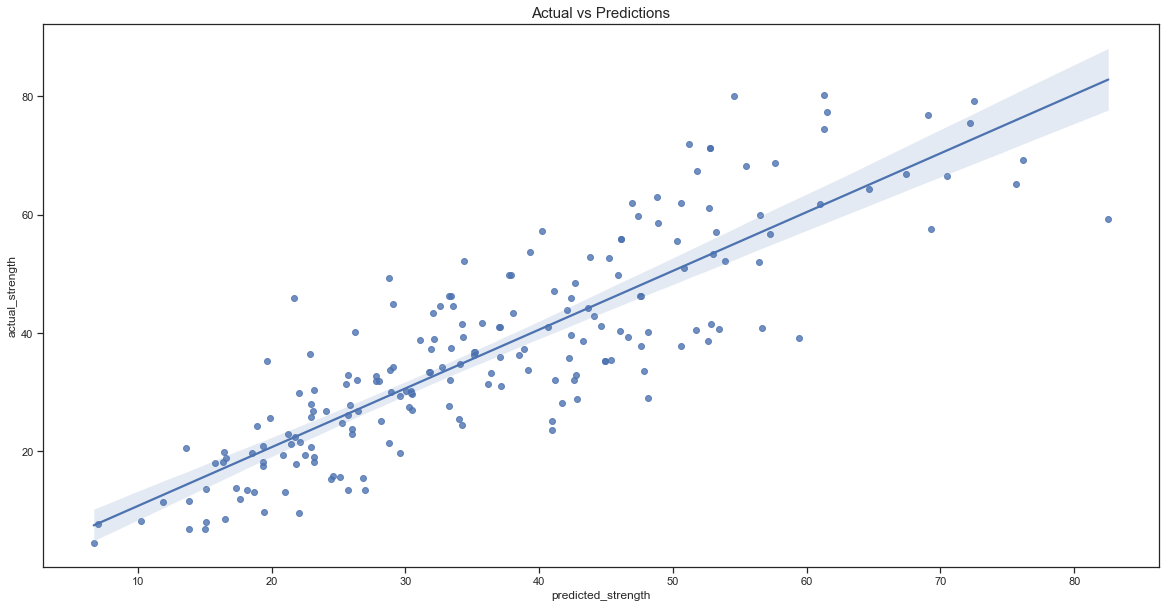

In [30]:
#visualize actual vs predicted values
sns.set(style = 'ticks',
        rc={'figure.figsize':(20,10)})

sns.regplot(x = 'predicted_strength', y = 'actual_strength', data = predictions_df)

plt.title('Actual vs Predictions', fontsize = 15);

#### Random Forest Regressor

In [31]:
#import model
from sklearn.ensemble import RandomForestRegressor

#initialize random forest regressor model
RND = RandomForestRegressor(ccp_alpha = 0.0)

In [32]:
#fit model
RND.fit(X_train, y_train)

#determine feature importances

features = X.columns
importances = RND.feature_importances_

importances_df = pd.DataFrame(zip(features, importances)).sort_values(1, ascending = False)
importances_df.columns = ['Features', 'Importance']

importances_df

,Features,Importance
7,age,0.348123
0,cement,0.289162
4,superplasticizer,0.105275
3,water,0.097265
1,slag,0.077716
6,fine_aggregate,0.030860
5,coarse_aggregate,0.030404
2,fly_ash,0.021195


In [33]:
#predict values
y_pred = RND.predict(X_test)

#create predictions dataframe
predictions_df = pd.DataFrame(zip(y_test, y_pred))
predictions_df.columns = ['actual_strength', 'predicted_strength']

#merge features value to the predictions dataframe
predictions_df = X_test.reset_index(drop = True).join(predictions_df)
predictions_df.head()


,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,actual_strength,predicted_strength
0,133.00,200.00,0.00,192.00,0.00,927.4,839.20,3,6.883728,5.578633
1,218.23,54.64,123.78,140.75,11.91,1075.7,792.67,56,61.990787,58.222761
2,108.30,162.40,0.00,203.50,0.00,938.2,849.00,7,7.723510,9.354121
3,424.00,22.00,132.00,178.00,8.48,882.0,750.00,3,32.011386,31.803304
4,331.00,0.00,0.00,192.00,0.00,1025.0,821.00,7,17.436848,15.913506


In [34]:
#get mean predictions per age group

age_group = predictions_df.groupby(['age'])[['actual_strength', 'predicted_strength']].mean()
age_group

,actual_strength,predicted_strength
age,,
3,21.294705,21.322920
7,28.861817,25.495983
14,31.316627,30.638019
28,39.495168,39.488878
56,55.461843,53.653240
90,37.648524,37.449691
91,68.597937,67.115441
100,44.345717,44.983927
120,39.779318,38.812228


In [35]:
#evaluate random forest regressor model
r2 = r2_score(y_test, y_pred)
print(f'R-Squared: {round(r2,2)}')

R-Squared: 0.9


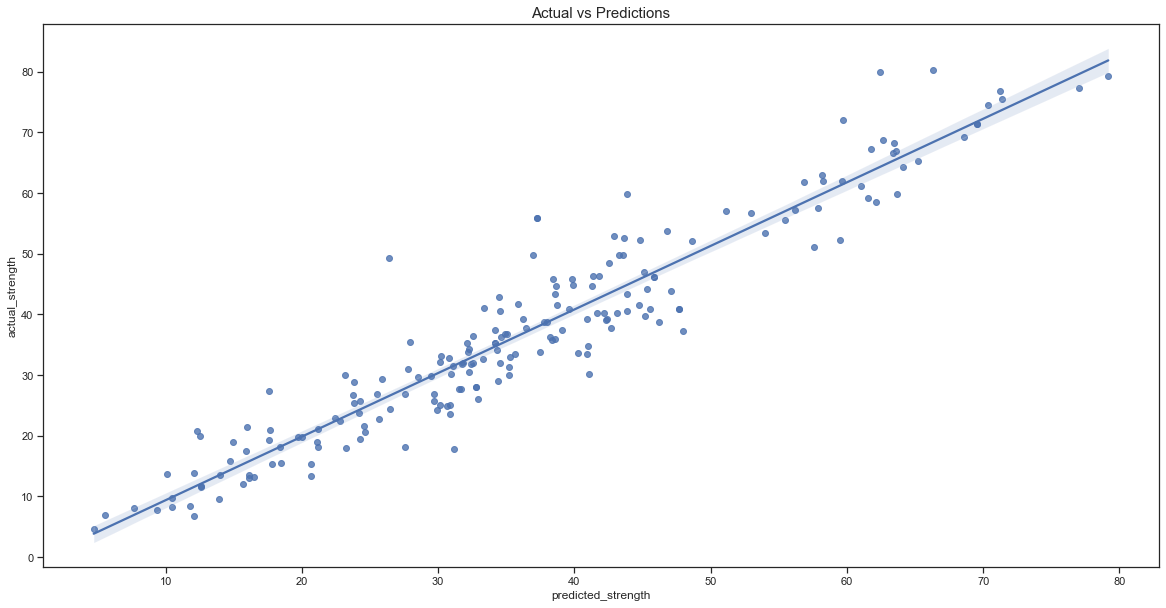

In [36]:
#visualize actual vs predicted values
sns.set(style = 'ticks',
        rc={'figure.figsize':(20,10)})

sns.regplot(x = 'predicted_strength', y = 'actual_strength', data = predictions_df)

plt.title('Actual vs Predictions', fontsize = 15);